In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src

/home/theo/mva/dlir/src


In [3]:
import torch
torch.cuda.is_available()

True

# Imports

In [4]:
from utils import *
from params import *

In [5]:
from metric import *

In [6]:
from dcgan import *
from data import *

In [114]:
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image

# Initialization

In [8]:
begin = time.time()
seed_everything(seed)

## Load Data

In [9]:
print('Number of dog images :', len(IMAGES))

Number of dog images : 20579


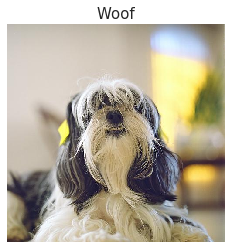

In [10]:
img = Image.open(IMAGES[0])
plt.imshow(img)
plt.title('Woof', size=15)
plt.axis(False)
plt.show()

## Seeding

# Dataset

In [11]:
%%time
dataset = DogDataset(DATA_PATH, base_transforms, additional_transforms)

CPU times: user 27.4 s, sys: 1.61 s, total: 29 s
Wall time: 41.5 s


In [12]:
nb_classes = len(dataset.classes)
print(f'Number of dog breeds : {nb_classes}')

Number of dog breeds : 120


In [13]:
nb_dogs = len(dataset)
print(f'Number of dog: {nb_dogs}')

Number of dog: 22125


In [17]:
# n = 5
# plt.figure(figsize=(15, 3))
# for idx, i in enumerate(np.random.choice(len(dataset), n)):
#     plt.subplot(1, n, idx + 1)
#     img, breed = dataset[i]
#     plt.imshow(img)
#     plt.axis(False)
    
#     plt.title(dataset.classes[breed])
# plt.show()

## Generate

In [18]:
def generate(generator, noise=None, races=None, n=5, n_plot=0, latent_dim=128):
    if noise is None:
        noise = torch.cuda.FloatTensor(n, latent_dim, 1, 1).normal_(0, 1)
    if races is None:
        races = torch.from_numpy(np.random.randint(0, nb_classes, size=n)).long().cuda()
        
    generated_images = generator(noise, races).add(1).div(2)
    images = generated_images.cpu().clone().detach().numpy().transpose(0, 2, 3, 1)
    
    if n_plot:
        plt.figure(figsize=(15, 3 * n_plot//5))
        for i in range(n_plot):
            plt.subplot(n_plot//5, 5, i+1)
            plt.imshow(images[i])
            plt.axis('off')
        plt.show()
    
    return generated_images

## Fit

In [19]:
import torch
import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F
from torch.nn import Parameter
from torch.autograd import Variable
from torch.optim.lr_scheduler import *

In [28]:
def fit(discriminator, generator, dataset, latent_dim=128, epochs=100, batch_size=32, 
        lr_d=1e-3, lr_g=1e-3, scheduler=False, label_smoothing=False,
        class_loss_weight=0., use_ft_matching=False,
        seed=2019, verbose=1, verbose_mifid=50):
    
    seed_everything(seed)
    fixed_noise = torch.FloatTensor(5, latent_dim, 1, 1).normal_(0, 1).cuda()
    fixed_races = torch.from_numpy(np.random.randint(0, nb_classes, size=5)).long().cuda()
    infos = {"discriminator_loss": [], "generator_loss": [], 'generator_lr': [], 'discriminator_lr': []}
    
    optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=lr_d, betas=(0.5, 0.999))
    optimizer_g = torch.optim.Adam(generator.parameters(), lr=lr_g, betas=(0.5, 0.999))
    
    scheduler_d = CosineAnnealingLR(optimizer_d, T_max=epochs, eta_min=1e-5)
    scheduler_g = CosineAnnealingLR(optimizer_g, T_max=epochs, eta_min=1e-5)
    
    loss_fn = nn.BCEWithLogitsLoss(reduction='sum')
    loss_classes_fn = nn.CrossEntropyLoss(reduction='sum')
    loss_ft_matching = nn.MSELoss(reduction='sum')
    
    real_label = 0.9 if label_smoothing else 1.
    fake_label = 0.
    
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=4, shuffle=True)

    for epoch in range(epochs):
        start_time = time.time()  
        d_loss = 0
        g_loss = 0
        
        if scheduler:
            scheduler_d.step()
            scheduler_g.step()
            lr_d = np.mean([param_group['lr'] for param_group in optimizer_d.param_groups])
            lr_g = np.mean([param_group['lr'] for param_group in optimizer_g.param_groups])
            
        for x, y in loader:
            t0 = time.time()

            ########   Update discriminator ########

            discriminator.zero_grad()
            batch_size = x.size(0)

            # Real images

            labels = torch.full((batch_size, 1), real_label).cuda()

            output, out_classes, _ = discriminator(x.cuda(), y.cuda())

            loss_real = loss_fn(output, labels)
            if class_loss_weight:
                loss_real += class_loss_weight * loss_classes_fn(out_classes, y.cuda())
            loss_real.backward()

            # Fake images

            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_races = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
            fake = generator(noise, fake_races)

            labels.fill_(fake_label)
            output, _, _ = discriminator(fake.detach(), fake_races)

            loss_fake = loss_fn(output, labels)
            loss_fake.backward()
            optimizer_d.step()
            
            d_loss += (loss_real + loss_fake).item() / len(dataset)
            
            
            ########   Update Generator   ########
            
            generator.zero_grad()
            labels.fill_(real_label)
            
            noise = torch.cuda.FloatTensor(batch_size, latent_dim, 1, 1).normal_(0, 1)
            fake_races = torch.from_numpy(np.random.randint(0, nb_classes, size=batch_size)).long().cuda()
            
            output_fake, _, features_fake = discriminator(fake, fake_races)
            
            if use_ft_matching:
                _, _, features_real = discriminator(x.cuda(), y.cuda())
                loss_g = loss_ft_matching(torch.mean(features_real, 0), torch.mean(features_fake, 0))
            else:
                loss_g = loss_fn(output_fake, labels)
                
            loss_g.backward()
            
            g_loss += loss_g.item() / len(dataset)
            optimizer_g.step()   

        elapsed_time = time.time() - start_time
        
        infos['discriminator_loss'].append(d_loss)
        infos['generator_loss'].append(g_loss)
        infos['generator_lr'].append(lr_g)
        infos['discriminator_lr'].append(lr_d)
        
        if (epoch + 1) % verbose == 0:
            elapsed_time = elapsed_time * verbose
            print(f'Epoch {epoch+1}/{epochs}     lr_g={lr_g:.1e}     lr_d={lr_d:.1e}', end='     ')
            print(f'disc_loss={d_loss:.3f}     gen_loss={g_loss:.3f}     t={elapsed_time:.0f}s')
            if (epoch + 1) % verbose_mifid == 0 and epoch > 100:
                score = tmp_eval(generator, n_images=10000, latent_dim=latent_dim)
                seed_everything(seed + epoch)
                print(f'\n -> FID at epoch {epoch+1} is {score:.3f} \n')
            elif (epoch + 1) % 10 == 0:
                generate(generator, noise=fixed_noise, races=fixed_races, n=5, n_plot=5, latent_dim=latent_dim)
                
    return infos

# Training

In [29]:
seed_everything(seed)

In [117]:
latent_dim = 100

use_bn = True
n_gen = 128
n_dis = 128

use_embed = False
embed_dim = 8

In [118]:
n_gen = 128
n_dis = 128
nb_ft = 1

In [119]:
batch_size = 64
lr_g = 1e-3  # tweak !
lr_d = 5e-4  # tweak !

scheduler = False
epochs = 200

In [120]:
class_loss_weight = 0 #0.5
use_ft_matching = False
label_smoothing = False

In [121]:
discriminator = DCGanDiscriminator(
    n=n_gen, 
    nb_ft=nb_ft,
    nb_classes=nb_classes, 
    embedding_dim=embed_dim, 
    use_embed=use_embed,
    use_bn=use_bn,
).cuda()

generator = DCGanGenerator(
    n=n_dis, 
    latent_dim=latent_dim, 
    nb_classes=nb_classes, 
    embedding_dim=embed_dim,
    use_embed=use_embed,
    use_bn=use_bn,
).cuda()

discriminator.apply(weights_init)
generator.apply(weights_init)

print('Build DCGAN.')

Build DCGAN.


Epoch 1/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.787     gen_loss=7.018     t=42s
Epoch 2/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.293     gen_loss=2.526     t=43s
Epoch 3/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.231     gen_loss=2.406     t=43s
Epoch 4/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.334     gen_loss=1.934     t=43s
Epoch 5/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.353     gen_loss=1.695     t=43s
Epoch 6/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.258     gen_loss=1.982     t=44s
Epoch 7/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.274     gen_loss=2.011     t=44s
Epoch 8/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.301     gen_loss=1.852     t=44s
Epoch 9/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.314     gen_loss=1.680     t=44s
Epoch 10/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.353     gen_loss=1.548     t=44s


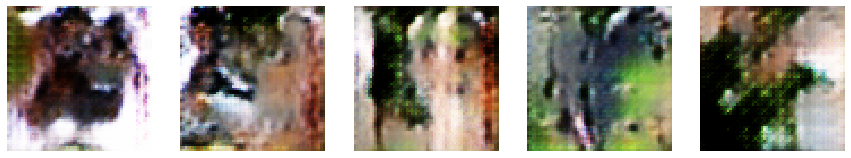

Epoch 11/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.336     gen_loss=1.580     t=44s
Epoch 12/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.319     gen_loss=1.559     t=44s
Epoch 13/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.307     gen_loss=1.673     t=44s
Epoch 14/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.290     gen_loss=1.663     t=44s
Epoch 15/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.294     gen_loss=1.636     t=44s
Epoch 16/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.270     gen_loss=1.685     t=44s
Epoch 17/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.260     gen_loss=1.715     t=44s
Epoch 18/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.229     gen_loss=1.775     t=44s
Epoch 19/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.247     gen_loss=1.822     t=44s
Epoch 20/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.206     gen_loss=1.789     t=44s


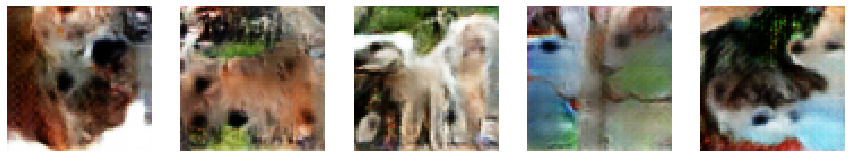

Epoch 21/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.205     gen_loss=1.829     t=44s
Epoch 22/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.179     gen_loss=1.803     t=44s
Epoch 23/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.145     gen_loss=1.880     t=44s
Epoch 24/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.132     gen_loss=1.899     t=44s
Epoch 25/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.120     gen_loss=1.950     t=44s
Epoch 26/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.077     gen_loss=2.044     t=44s
Epoch 27/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.058     gen_loss=2.065     t=44s
Epoch 28/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.020     gen_loss=2.160     t=44s
Epoch 29/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.021     gen_loss=2.238     t=44s
Epoch 30/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.978     gen_loss=2.235     t=44s


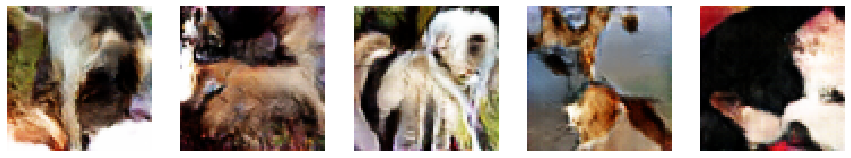

Epoch 31/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.951     gen_loss=2.367     t=44s
Epoch 32/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.919     gen_loss=2.433     t=44s
Epoch 33/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.872     gen_loss=2.504     t=44s
Epoch 34/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.886     gen_loss=2.571     t=44s
Epoch 35/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.886     gen_loss=2.544     t=44s
Epoch 36/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.792     gen_loss=2.739     t=44s
Epoch 37/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.816     gen_loss=2.855     t=44s
Epoch 38/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.793     gen_loss=2.843     t=44s
Epoch 39/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.771     gen_loss=2.908     t=44s
Epoch 40/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.774     gen_loss=3.015     t=44s


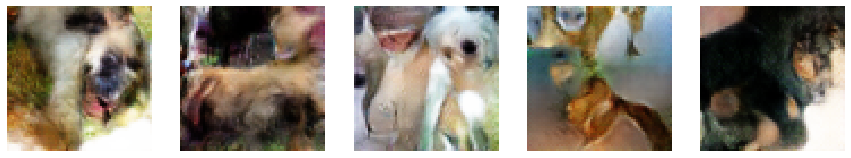

Epoch 41/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.624     gen_loss=2.991     t=44s
Epoch 42/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.726     gen_loss=3.119     t=44s
Epoch 43/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.782     gen_loss=3.067     t=44s
Epoch 44/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.630     gen_loss=3.215     t=44s
Epoch 45/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.559     gen_loss=3.416     t=44s
Epoch 46/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.589     gen_loss=3.551     t=44s
Epoch 47/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.541     gen_loss=3.710     t=44s
Epoch 48/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.837     gen_loss=3.328     t=44s
Epoch 49/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.607     gen_loss=3.448     t=44s
Epoch 50/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.669     gen_loss=3.640     t=44s


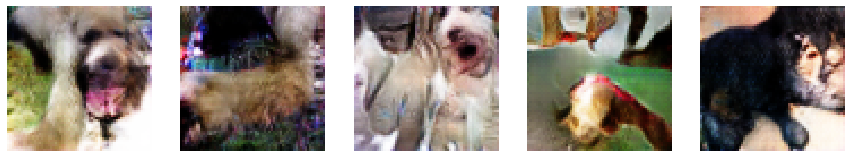

Epoch 51/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.415     gen_loss=3.542     t=44s
Epoch 52/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.891     gen_loss=3.459     t=44s
Epoch 53/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.468     gen_loss=3.611     t=44s
Epoch 54/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.553     gen_loss=3.646     t=44s
Epoch 55/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.541     gen_loss=3.757     t=44s
Epoch 56/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.391     gen_loss=4.001     t=44s
Epoch 57/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.196     gen_loss=2.834     t=44s
Epoch 58/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.494     gen_loss=3.739     t=44s
Epoch 59/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.358     gen_loss=3.972     t=44s
Epoch 60/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.572     gen_loss=4.065     t=44s


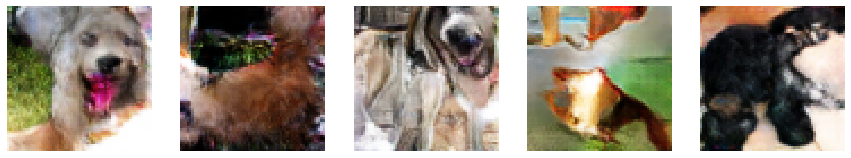

Epoch 61/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.562     gen_loss=3.997     t=44s
Epoch 62/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.351     gen_loss=4.103     t=44s
Epoch 63/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.686     gen_loss=4.150     t=44s
Epoch 64/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.273     gen_loss=4.045     t=44s
Epoch 65/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.266     gen_loss=4.579     t=44s
Epoch 66/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.806     gen_loss=3.921     t=44s
Epoch 67/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.432     gen_loss=4.353     t=44s
Epoch 68/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.250     gen_loss=4.353     t=44s
Epoch 69/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.515     gen_loss=4.598     t=44s
Epoch 70/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.233     gen_loss=4.577     t=44s


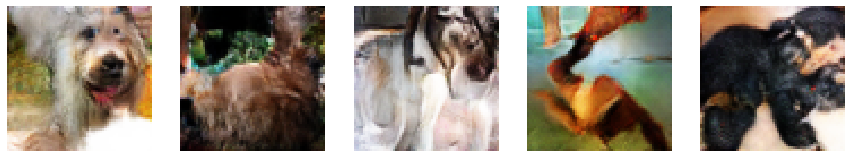

Epoch 71/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.617     gen_loss=4.470     t=44s
Epoch 72/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.563     gen_loss=4.372     t=44s
Epoch 73/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.321     gen_loss=4.397     t=44s
Epoch 74/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.394     gen_loss=4.635     t=44s
Epoch 75/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.228     gen_loss=4.654     t=44s
Epoch 76/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.416     gen_loss=4.692     t=44s
Epoch 77/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.224     gen_loss=4.983     t=44s
Epoch 78/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.792     gen_loss=4.374     t=44s
Epoch 79/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.234     gen_loss=4.687     t=44s
Epoch 80/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.562     gen_loss=4.762     t=44s


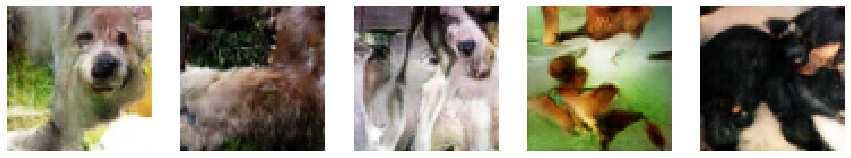

Epoch 81/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.234     gen_loss=4.726     t=44s
Epoch 82/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.454     gen_loss=4.748     t=44s
Epoch 83/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.421     gen_loss=4.518     t=44s
Epoch 84/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.357     gen_loss=4.966     t=44s
Epoch 85/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.153     gen_loss=5.057     t=44s
Epoch 86/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.557     gen_loss=4.779     t=44s
Epoch 87/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.410     gen_loss=5.004     t=44s
Epoch 88/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.173     gen_loss=4.979     t=44s
Epoch 89/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.262     gen_loss=5.341     t=44s
Epoch 90/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.953     gen_loss=3.641     t=44s


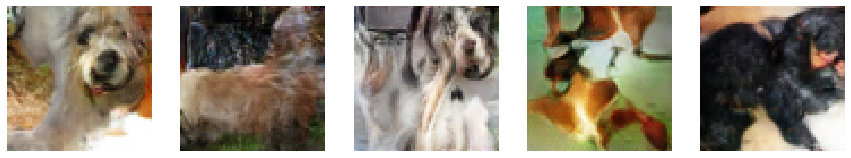

Epoch 91/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.157     gen_loss=4.899     t=44s
Epoch 92/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.367     gen_loss=4.992     t=44s
Epoch 93/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.179     gen_loss=5.267     t=44s
Epoch 94/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.408     gen_loss=5.014     t=44s
Epoch 95/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.415     gen_loss=5.178     t=44s
Epoch 96/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.141     gen_loss=5.248     t=44s
Epoch 97/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.484     gen_loss=5.007     t=44s
Epoch 98/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.325     gen_loss=5.262     t=44s
Epoch 99/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.122     gen_loss=5.361     t=44s
Epoch 100/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.295     gen_loss=5.478     t=44s


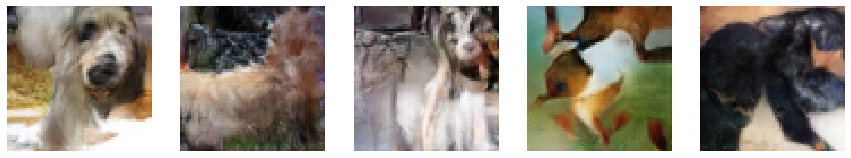

Epoch 101/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.947     gen_loss=3.946     t=44s
Epoch 102/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.154     gen_loss=5.031     t=44s
Epoch 103/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.370     gen_loss=5.219     t=44s
Epoch 104/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.113     gen_loss=5.350     t=44s
Epoch 105/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.420     gen_loss=5.099     t=44s
Epoch 106/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.502     gen_loss=4.880     t=44s
Epoch 107/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.319     gen_loss=5.141     t=44s
Epoch 108/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.187     gen_loss=5.444     t=44s
Epoch 109/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.400     gen_loss=5.315     t=44s
Epoch 110/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.204     gen_loss=5.534     t=44s


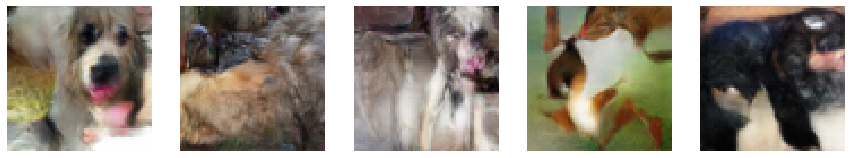

Epoch 111/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.090     gen_loss=5.665     t=44s
Epoch 112/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.545     gen_loss=5.054     t=44s
Epoch 113/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.419     gen_loss=5.395     t=44s
Epoch 114/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.145     gen_loss=5.471     t=44s
Epoch 115/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.106     gen_loss=5.814     t=44s
Epoch 116/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.078     gen_loss=6.037     t=44s
Epoch 117/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=1.013     gen_loss=4.257     t=44s
Epoch 118/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.245     gen_loss=5.432     t=44s
Epoch 119/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.106     gen_loss=5.604     t=44s
Epoch 120/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.275     gen_loss=5.471     t=44s


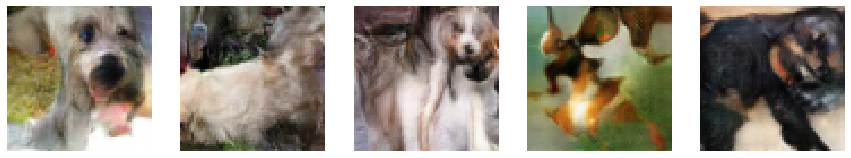

Epoch 121/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.419     gen_loss=5.357     t=44s
Epoch 122/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.089     gen_loss=5.729     t=44s
Epoch 123/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.596     gen_loss=4.954     t=44s
Epoch 124/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.115     gen_loss=5.629     t=44s
Epoch 125/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.071     gen_loss=5.953     t=44s
Epoch 126/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.668     gen_loss=5.298     t=44s
Epoch 127/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.135     gen_loss=5.595     t=44s
Epoch 128/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.150     gen_loss=5.865     t=44s
Epoch 129/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.064     gen_loss=6.069     t=44s
Epoch 130/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.556     gen_loss=5.181     t=44s


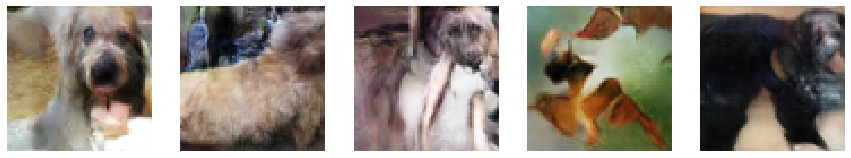

Epoch 131/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.296     gen_loss=5.882     t=44s
Epoch 132/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.289     gen_loss=5.713     t=44s
Epoch 133/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.076     gen_loss=5.943     t=44s
Epoch 134/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.351     gen_loss=6.157     t=44s
Epoch 135/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.169     gen_loss=5.847     t=44s
Epoch 136/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.082     gen_loss=6.093     t=44s
Epoch 137/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.053     gen_loss=6.341     t=44s
Epoch 138/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.614     gen_loss=6.047     t=44s
Epoch 139/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.150     gen_loss=5.877     t=44s
Epoch 140/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.071     gen_loss=6.069     t=44s


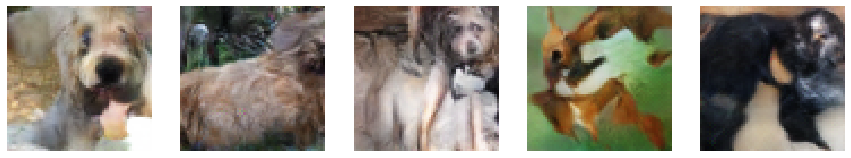

Epoch 141/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.277     gen_loss=6.233     t=44s
Epoch 142/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.097     gen_loss=6.309     t=44s
Epoch 143/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.076     gen_loss=6.591     t=44s
Epoch 144/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.671     gen_loss=5.761     t=44s
Epoch 145/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.126     gen_loss=5.930     t=44s
Epoch 146/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.249     gen_loss=6.163     t=44s
Epoch 147/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.061     gen_loss=6.155     t=44s
Epoch 148/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.236     gen_loss=6.302     t=44s
Epoch 149/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.359     gen_loss=6.287     t=44s
Epoch 150/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.116     gen_loss=6.218     t=44s

 -> MiFID at epoch 150 is 61.

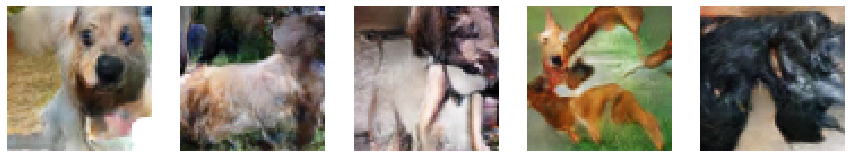

Epoch 161/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.078     gen_loss=6.731     t=44s
Epoch 162/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.271     gen_loss=6.482     t=44s
Epoch 163/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.363     gen_loss=6.394     t=44s
Epoch 164/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.064     gen_loss=6.395     t=44s
Epoch 165/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.046     gen_loss=6.705     t=44s
Epoch 166/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.546     gen_loss=5.831     t=44s
Epoch 167/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.059     gen_loss=6.375     t=44s
Epoch 168/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.047     gen_loss=6.686     t=44s
Epoch 169/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.429     gen_loss=6.611     t=44s
Epoch 170/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.098     gen_loss=6.483     t=44s


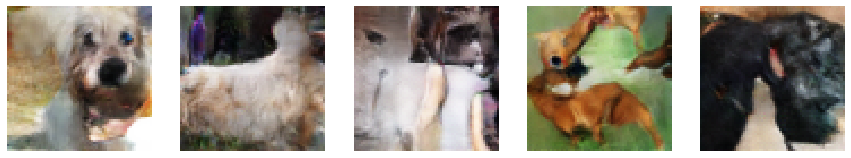

Epoch 171/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.071     gen_loss=6.700     t=44s
Epoch 172/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.277     gen_loss=6.602     t=44s
Epoch 173/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.045     gen_loss=6.681     t=44s
Epoch 174/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.309     gen_loss=6.464     t=44s
Epoch 175/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.255     gen_loss=6.659     t=44s
Epoch 176/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.069     gen_loss=6.541     t=44s
Epoch 177/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.044     gen_loss=6.814     t=44s
Epoch 178/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.381     gen_loss=6.826     t=44s
Epoch 179/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.081     gen_loss=6.642     t=44s
Epoch 180/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.068     gen_loss=6.970     t=44s


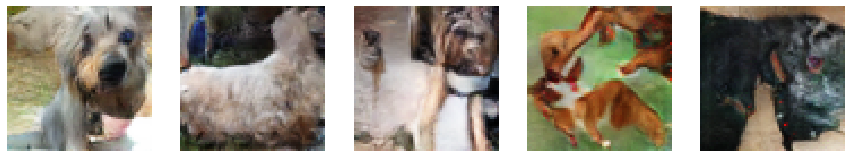

Epoch 181/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.303     gen_loss=6.681     t=44s
Epoch 182/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.057     gen_loss=6.917     t=44s
Epoch 183/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.039     gen_loss=7.078     t=44s
Epoch 184/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.463     gen_loss=6.486     t=44s
Epoch 185/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.111     gen_loss=6.990     t=44s
Epoch 186/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.053     gen_loss=6.968     t=44s
Epoch 187/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.600     gen_loss=5.808     t=44s
Epoch 188/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.124     gen_loss=6.668     t=44s
Epoch 189/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.045     gen_loss=6.766     t=44s
Epoch 190/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.220     gen_loss=6.827     t=44s


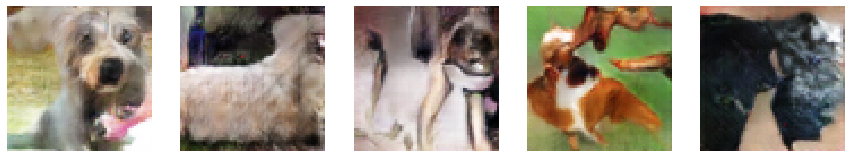

Epoch 191/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.093     gen_loss=6.948     t=44s
Epoch 192/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.040     gen_loss=7.042     t=44s
Epoch 193/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.097     gen_loss=7.522     t=44s
Epoch 194/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.328     gen_loss=7.304     t=44s
Epoch 195/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.059     gen_loss=6.915     t=44s
Epoch 196/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.344     gen_loss=6.572     t=44s
Epoch 197/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.059     gen_loss=6.949     t=44s
Epoch 198/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.199     gen_loss=7.043     t=44s
Epoch 199/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.047     gen_loss=7.144     t=44s
Epoch 200/200     lr_g=1.0e-03     lr_d=5.0e-04     disc_loss=0.032     gen_loss=7.334     t=44s

 -> MiFID at epoch 200 is 56.

In [122]:
infos = fit(discriminator, generator, dataset, latent_dim=latent_dim,
            epochs=epochs, batch_size=batch_size, 
            lr_g=lr_g, lr_d=lr_d, scheduler=scheduler,
            class_loss_weight=class_loss_weight, 
            use_ft_matching=use_ft_matching, 
            label_smoothing=label_smoothing)

### Loss Curves

In [115]:
save_model_weights(generator, f'cond_gen_{str(datetime.date.today())}.pth')
save_model_weights(discriminator, f'cond_dis_{str(datetime.date.today())}.pth')


 -> Saving weights to ../output/cond_gen_2020-03-31.pth


 -> Saving weights to ../output/cond_dis_2020-03-31.pth



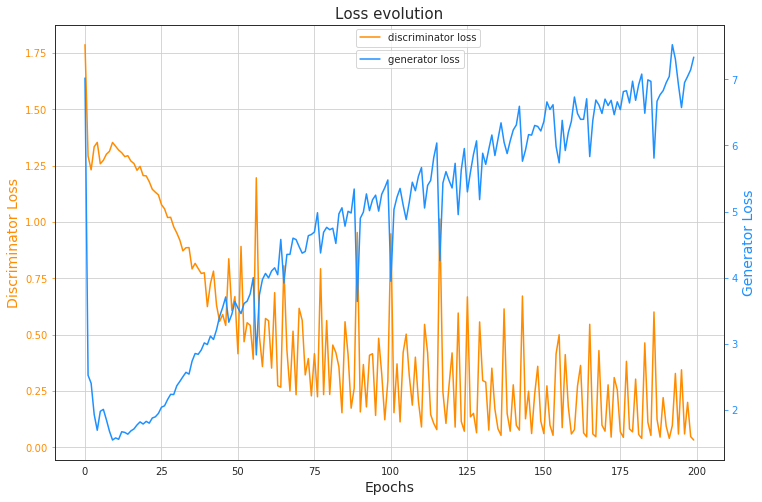

In [123]:
plot_losses(infos)

### Generated Doggos

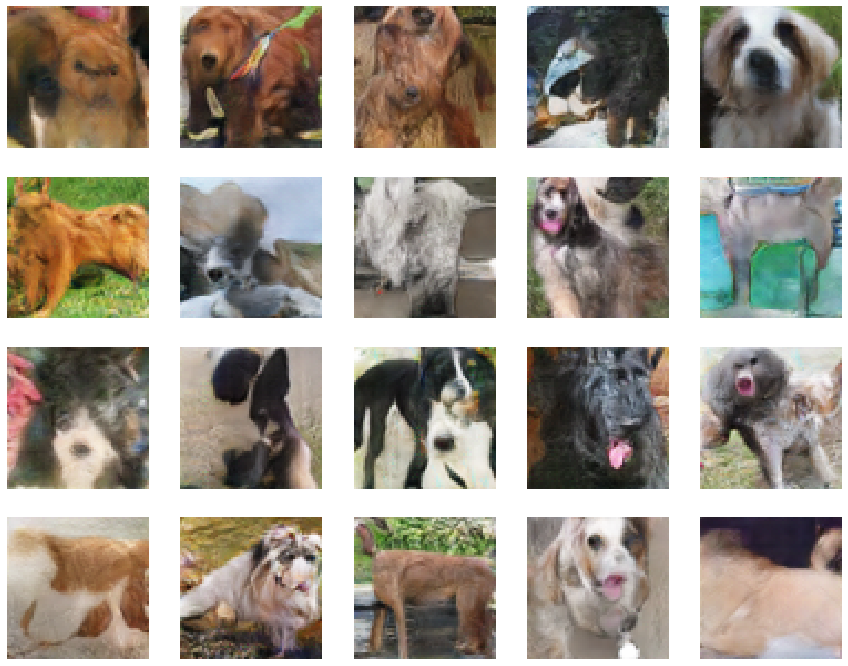

In [124]:
_ = generate(generator, n=20, n_plot=20, latent_dim=latent_dim)

### Latent Walk

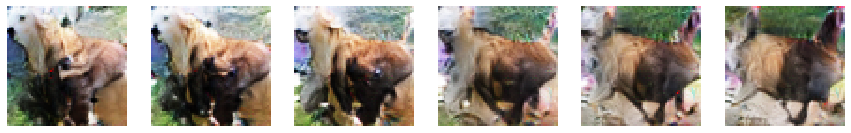

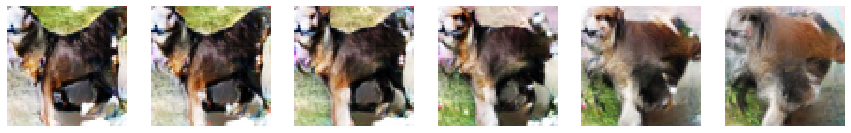

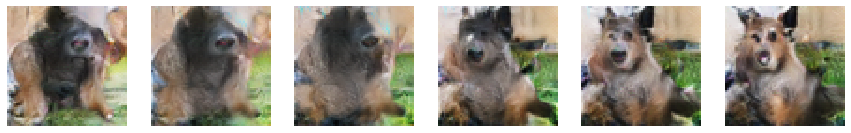

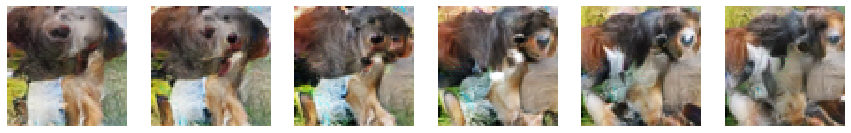

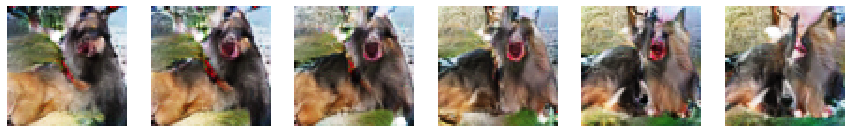

In [125]:
for i in range(5):
    latent_walk(generator, n=5, latent_dim=latent_dim)

In [126]:
print(f"Done in {(time.time() - begin)/60:.1f} minutes")

Done in 414.3 minutes
